In [34]:
from IPython.display import clear_output
import time
try:

    !pip install h5py
    !pip install pandas
    !pip install Pillow
    !pip install matplotlib
    #!pip install sklearn
    !pip install scikit-learn
    !pip install torch
    !pip install torchvision
    time.sleep(5)
    clear_output()
    print("Packages successfully installed")

except:
    print("error installing packages")



Packages successfully installed


In [77]:
import h5py
import pandas as pd
import numpy as np
from PIL import Image
import io
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
from torchsummary import summary

In [36]:
#Brings in YOUR google drive directory, save data to google drive so that you
#dont have to download everytime
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [52]:
import cv2

In [67]:
# This function from https://www.kaggle.com/competitions/isic-2024-challenge/discussion/519735
def remove_hair(image):
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (10,10))
        blackhat = cv2.morphologyEx(gray,cv2.MORPH_BLACKHAT,kernel)

        _, thresh = cv2.threshold(blackhat, 10 ,255, cv2.THRESH_BINARY)
        inpainted_image = cv2.inpaint(image, thresh, 1, cv2.INPAINT_TELEA)
        return inpainted_image

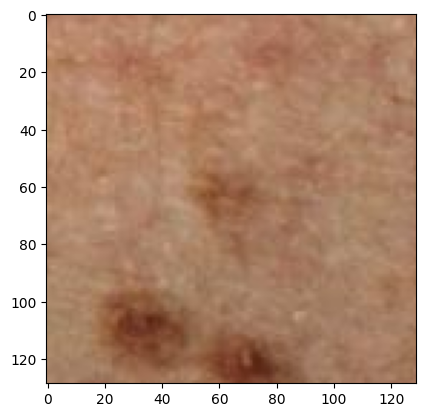

In [68]:
#test_images["ISIC_0015740"]
test_images_path = "/content/drive/MyDrive/cse151a-group-project/isic-2024-challenge/train-image/image/ISIC_3723665.jpg"
test_image = cv2.imread(test_images_path)
test_image = cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB)
plt.imshow(test_image)
plt.show()


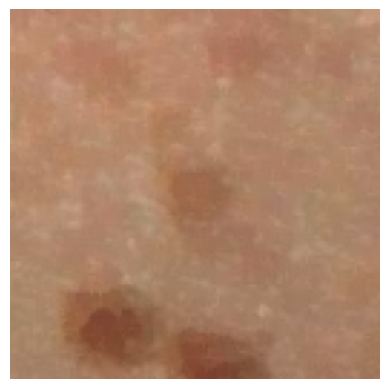

In [69]:
#plt.imshow(remove_hair(np.array(test_images["ISIC_0015740"])))
plt.imshow(remove_hair(np.array(test_image)))
plt.axis('off')
plt.show()

In [97]:

# Define the custom dataset class
class ISIC2024Dataset(Dataset):
    def __init__(self, metadata: pd.DataFrame, file_hdf: str, transform=None):
        self.metadata = metadata
        self.fp_hdf = h5py.File(file_hdf, mode="r")
        self.transform = transform

    def __len__(self):
        return len(self.metadata)

    def __getitem__(self, item):
        isic_row = self.metadata.iloc[item]
        isic_id = isic_row.isic_id
        image = np.array(Image.open(io.BytesIO(self.fp_hdf[isic_id][()])))
        label = isic_row.target

        if self.transform:
            image = self.transform(image)

        return image, label



In [98]:

#path to ISIC 2024 dataset on my google drive
#google_drive_path ="/content/drive/MyDrive/cse151a-group-project/isic-2024-challenge/train-image/image"
google_drive_path ="/content/drive/MyDrive/cse151a-group-project/isic-2024-challenge/train-metadata.csv"

In [99]:
# Load metadata
#metadata = pd.read_csv('isic-2024-challenge/train-metadata.csv')
metadata = pd.read_csv(google_drive_path)
metadata = metadata[['isic_id', 'target']]

# Ensure an even split of target=0 and target=1
target_0 = metadata[metadata['target'] == 0].sample(n=10000, random_state=42)
target_1 = metadata[metadata['target'] == 1].sample(n=393, random_state=42)

balanced_metadata = pd.concat([target_0, target_1]).reset_index(drop=True)

# Split the metadata into training and validation sets
train_metadata, val_metadata = train_test_split(balanced_metadata, test_size=0.2, random_state=42)


<ipython-input-99-df810201d359>:3: DtypeWarning: Columns (51,52) have mixed types. Specify dtype option on import or set low_memory=False.
  metadata = pd.read_csv(google_drive_path)


In [100]:
google_drive_train_image = "/content/drive/MyDrive/cse151a-group-project/isic-2024-challenge/train-image.hdf5"
google_drive_test_image = "/content/drive/MyDrive/cse151a-group-project/isic-2024-challenge/test-image.hdf5"


## Pre-Processing

Standaring

In [101]:
# Define image transformations
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create dataset objects
#train_dataset = ISIC2024Dataset(train_metadata, 'isic-2024-challenge/train-image.hdf5', transform=transform)
#val_dataset = ISIC2024Dataset(val_metadata, 'isic-2024-challenge/train-image.hdf5', transform=transform)
train_dataset = ISIC2024Dataset(train_metadata, google_drive_train_image, transform=transform)
val_dataset = ISIC2024Dataset(val_metadata, google_drive_train_image, transform=transform)




In [102]:
# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=0)



In [103]:
# Define the model
model = models.resnet18(pretrained=True)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 1)  # Binary classification

# Move the model to the GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Define loss function and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
summary(model,input_size=(3,224,224))


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [104]:
# Training loop
num_epochs = 10

epoch_losses_train = []
epoch_accuracy_train = []
epoch_losses_test=[]
epoch_accuracy_test=[]


for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device).float()

        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs.squeeze(), labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

        # Calculate accuracy
        predicted = (torch.sigmoid(outputs.squeeze()) > 0.5).float()
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_accuracy = correct / total
    epoch_losses_train.append(epoch_loss)
    epoch_accuracy_train.append(epoch_accuracy)

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}')


    # Evaluation loop
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0



    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device).float()

            outputs = model(images)
            loss = criterion(outputs.squeeze(), labels)

            val_loss += loss.item() * images.size(0)

            predicted = (torch.sigmoid(outputs.squeeze()) > 0.5).float()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss = val_loss / len(val_loader.dataset)
    accuracy = correct / total
    epoch_losses_test.append(val_loss)
    epoch_accuracy_test.append(accuracy)
    print(f'Validation Loss: {val_loss:.4f}, Accuracy: {accuracy:.4f}')


Epoch [1/10], Loss: 0.1698, Accuracy: 0.9561
Validation Loss: 0.1536, Accuracy: 0.9577
Epoch [2/10], Loss: 0.1391, Accuracy: 0.9632
Validation Loss: 0.1710, Accuracy: 0.9577
Epoch [3/10], Loss: 0.1301, Accuracy: 0.9633
Validation Loss: 0.1347, Accuracy: 0.9577
Epoch [4/10], Loss: 0.1218, Accuracy: 0.9632
Validation Loss: 0.1201, Accuracy: 0.9582
Epoch [5/10], Loss: 0.1216, Accuracy: 0.9633
Validation Loss: 0.1283, Accuracy: 0.9577
Epoch [6/10], Loss: 0.1230, Accuracy: 0.9643
Validation Loss: 0.1213, Accuracy: 0.9577
Epoch [7/10], Loss: 0.1160, Accuracy: 0.9646
Validation Loss: 0.1141, Accuracy: 0.9582
Epoch [8/10], Loss: 0.1159, Accuracy: 0.9645
Validation Loss: 0.1384, Accuracy: 0.9601
Epoch [9/10], Loss: 0.1154, Accuracy: 0.9639
Validation Loss: 0.1248, Accuracy: 0.9577
Epoch [10/10], Loss: 0.1219, Accuracy: 0.9638
Validation Loss: 0.1730, Accuracy: 0.9567


In [87]:
# Evaluation loop
#moved to above loop
model.eval()
val_loss = 0.0
correct = 0
total = 0



with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device).float()

        outputs = model(images)
        loss = criterion(outputs.squeeze(), labels)

        val_loss += loss.item() * images.size(0)

        predicted = (torch.sigmoid(outputs.squeeze()) > 0.5).float()
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

val_loss = val_loss / len(val_loader.dataset)
accuracy = correct / total
print(f'Validation Loss: {val_loss:.4f}, Accuracy: {accuracy:.4f}')


Validation Loss: 0.1176, Accuracy: 0.9582


In [88]:
metadata['target'].value_counts()

target
0    400666
1       393
Name: count, dtype: int64

In [105]:
print(len(epoch_losses_train))
print(len(epoch_losses_accuracy))

10
10


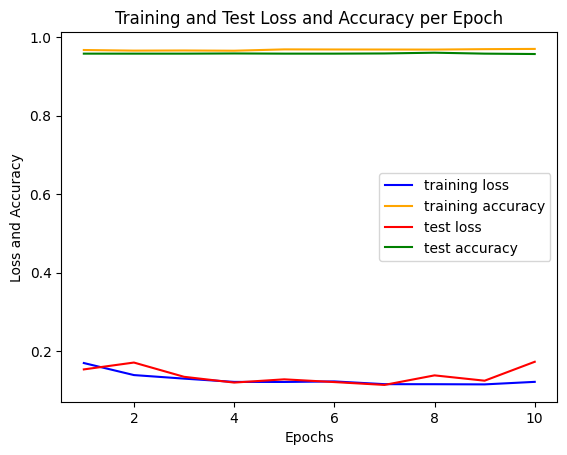

In [106]:
plt.plot(range(1,len(epoch_losses_train)+1),epoch_losses_train,
         label='training loss',color='blue')
plt.plot(range(1,len(epoch_losses_accuracy)+1),epoch_losses_accuracy,
         label='training accuracy',color='orange')

plt.plot(range(1,len(epoch_losses_test)+1),epoch_losses_test,
         label='test loss',color='red')

plt.plot(range(1,len(epoch_accuracy_test)+1),epoch_accuracy_test,
         label='test accuracy',color='green')

plt.title("Training and Test Loss and Accuracy per Epoch")
plt.xlabel("Epochs")
plt.ylabel("Loss and Accuracy")
plt.legend()
plt.show()

### FCN8 Implementation

In [ ]:
import torch.nn as nn

class FCN8s(nn.Module):

    def __init__(self, n_class=12):
        super(FCN8s, self).__init__()

        ################################################################################
        # TODO: Implement the layers for FCN8s.                                        #
        ################################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        self.conv1_1 = nn.Conv2d(3,64,3,padding=100,stride=1)
        self.relu1_1 = nn.ReLU(inplace=True)
        self.conv1_2 = nn.Conv2d(64,64,3,padding=1,stride=1)
        self.relu1_2 = nn.ReLU(inplace=True)
        self.pool1 = nn.MaxPool2d(2,ceil_mode=True)

        self.conv2_1 = nn.Conv2d(64,128,3,padding=1,stride=1)
        self.relu2_1 = nn.ReLU(inplace=True)
        self.conv2_2 = nn.Conv2d(128,128,3,padding=1,stride=1)
        self.relu2_2 = nn.ReLU(inplace=True)
        self.pool2 = nn.MaxPool2d(2,ceil_mode=True)

        self.conv3_1 = nn.Conv2d(128,256,3,padding=1,stride=1)
        self.relu3_1 = nn.ReLU(inplace=True)
        self.conv3_2 = nn.Conv2d(256,256,3,padding=1,stride=1)
        self.relu3_2 = nn.ReLU(inplace=True)
        self.conv3_3 = nn.Conv2d(256,256,3,padding=1,stride=1)
        self.relu3_3 = nn.ReLU(inplace=True)
        self.pool3 = nn.MaxPool2d(2,ceil_mode=True)

        self.conv4_1 = nn.Conv2d(256,512,3,padding=1,stride=1)
        self.relu4_1 = nn.ReLU(inplace=True)
        self.conv4_2 = nn.Conv2d(512,512,3,padding=1,stride=1)
        self.relu4_2 = nn.ReLU(inplace=True)
        self.conv4_3 = nn.Conv2d(512,512,3,padding=1,stride=1)
        self.relu4_3 = nn.ReLU(inplace=True)
        self.pool4 = nn.MaxPool2d(2,ceil_mode=True)

        self.conv5_1 = nn.Conv2d(512,512,3,padding=1,stride=1)
        self.relu5_1 = nn.ReLU(inplace=True)
        self.conv5_2 = nn.Conv2d(512,512,3,padding=1,stride=1)
        self.relu5_2 = nn.ReLU(inplace=True)
        self.conv5_3 = nn.Conv2d(512,512,3,padding=1,stride=1)
        self.relu5_3 = nn.ReLU(inplace=True)
        self.pool5 = nn.MaxPool2d(2,ceil_mode=True)

        self.fc6 = nn.Conv2d(512,4096,7,stride=1,padding=0)
        self.relufc6 = nn.ReLU(inplace=True)
        self.dropoutfc6 = nn.Dropout2d(p=0.5)

        self.fc7 = nn.Conv2d(4096,4096,1,stride=1,padding=0)
        self.relufc7 = nn.ReLU(inplace=True)
        self.dropoutfc7 = nn.Dropout2d(p=0.5)


        self.score = nn.Conv2d(4096,n_class,1,stride=1,padding=0)

        #self.trans_conv = nn.ConvTranspose2d(n_class,n_class,64,stride=32,padding=0,bias=False)

        self.score_pool_3 = nn.Conv2d(256,n_class,1,stride=1,padding=0)

        self.score_pool_4 = nn.Conv2d(512,n_class,1,stride=1,padding=0)

        self.upscore1 = nn.ConvTranspose2d(n_class,n_class,4,stride=2,bias=False)

        self.upscore2 = nn.ConvTranspose2d(n_class,n_class,4,stride=2,bias=False)

        self.upscore3 = nn.ConvTranspose2d(n_class,n_class,16,stride=8,bias=False)




        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        ################################################################################
        #                                 END OF YOUR CODE                             #
        ################################################################################

        self._initialize_weights()

    def get_upsampling_weight(self, in_channels, out_channels, kernel_size):
        """Make a 2D bilinear kernel suitable for upsampling"""
        factor = (kernel_size + 1) // 2
        if kernel_size % 2 == 1:
            center = factor - 1
        else:
            center = factor - 0.5
        og = np.ogrid[:kernel_size, :kernel_size]
        filt = (1 - abs(og[0] - center) / factor) * \
               (1 - abs(og[1] - center) / factor)
        weight = np.zeros((in_channels, out_channels, kernel_size, kernel_size),
                          dtype=np.float64)
        weight[range(in_channels), range(out_channels), :, :] = filt
        return torch.from_numpy(weight).float()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                m.weight.data.zero_()
                if m.bias is not None:
                    m.bias.data.zero_()
            if isinstance(m, nn.ConvTranspose2d):
                assert m.kernel_size[0] == m.kernel_size[1]
                initial_weight = self.get_upsampling_weight(
                    m.in_channels, m.out_channels, m.kernel_size[0])
                m.weight.data.copy_(initial_weight)


    def forward(self, x):
        ################################################################################
        # TODO: Implement the forward pass for FCN8s.                                 #
        ################################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        input_shape = x.shape

        x = self.conv1_1(x)
        x = self.relu1_1(x)
        x = self.conv1_2(x)
        x = self.relu1_2(x)
        x = self.pool1(x)

        x = self.conv2_1(x)
        x = self.relu2_1(x)
        x = self.conv2_2(x)
        x = self.relu2_2(x)
        x = self.pool2(x)

        x = self.conv3_1(x)
        x = self.relu3_1(x)
        x = self.conv3_2(x)
        x = self.relu3_2(x)
        x = self.conv3_3(x)
        x = self.relu3_3(x)
        pool3 = self.pool3(x)

        x = self.conv4_1(pool3)
        x = self.relu4_1(x)
        x = self.conv4_2(x)
        x = self.relu4_2(x)
        x = self.conv4_3(x)
        x = self.relu4_3(x)
        pool4 = self.pool4(x)

        x = self.conv5_1(pool4)
        x = self.relu5_1(x)
        x = self.conv5_2(x)
        x = self.relu5_2(x)
        x = self.conv5_3(x)
        x = self.relu5_3(x)
        x = self.pool5(x)

        x = self.fc6(x)
        x = self.relufc6(x)
        x = self.dropoutfc6(x)

        x = self.fc7(x)
        x = self.relufc7(x)
        x = self.dropoutfc7(x)

        x = self.score(x)

        upscore_1 = self.upscore1(x)

        score_pool4 = self.score_pool_4(pool4)
        score_pool4 = score_pool4[:,:,5:5+upscore_1.size()[2],5:5+upscore_1.size()[3]]

        upscore_2 = self.upscore2(score_pool4+upscore_1)

        score_pool3 = self.score_pool_3(pool3)
        score_pool3 = score_pool3[:,:,9:9+upscore_2.size()[2],9:9+upscore_2.size()[3]]

        upscore_3 = self.upscore3(score_pool3+upscore_2)
        upscore_3 = upscore_3[:,:,31:31+input_shape[2],31:31+input_shape[3]]

        h=upscore_3

        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        ################################################################################
        #                                 END OF YOUR CODE                             #
        ################################################################################

        return h

    def copy_params_from_vgg16(self, vgg16):
        features = [
            self.conv1_1, self.relu1_1,
            self.conv1_2, self.relu1_2,
            self.pool1,
            self.conv2_1, self.relu2_1,
            self.conv2_2, self.relu2_2,
            self.pool2,
            self.conv3_1, self.relu3_1,
            self.conv3_2, self.relu3_2,
            self.conv3_3, self.relu3_3,
            self.pool3,
            self.conv4_1, self.relu4_1,
            self.conv4_2, self.relu4_2,
            self.conv4_3, self.relu4_3,
            self.pool4,
            self.conv5_1, self.relu5_1,
            self.conv5_2, self.relu5_2,
            self.conv5_3, self.relu5_3,
            self.pool5,
        ]
        for l1, l2 in zip(vgg16.features, features):
            if isinstance(l1, nn.Conv2d) and isinstance(l2, nn.Conv2d):
                assert l1.weight.size() == l2.weight.size()
                assert l1.bias.size() == l2.bias.size()
                l2.weight.data.copy_(l1.weight.data)
                l2.bias.data.copy_(l1.bias.data)
        for i, name in zip([0, 3], ['fc6', 'fc7']):
            l1 = vgg16.classifier[i]
            l2 = getattr(self, name)
            l2.weight.data.copy_(l1.weight.data.view(l2.weight.size()))
            l2.bias.data.copy_(l1.bias.data.view(l2.bias.size()))


In [ ]:
from FCN.trainer import Trainer
import torchvision

vgg16 = torchvision.models.vgg16(pretrained=True)

model8 = FCN8s(n_class=2)
model8.copy_params_from_vgg16(vgg16)
model8.to(device)

best_model_fcn8s = Trainer(
    model8,
    train_loader,
    val_loader,
    test_loader,
    num_epochs=20
)

In [ ]:
from FCN.trainer import visualize
visualize(best_model_fcn8s, test_loader)